<a href="https://colab.research.google.com/github/Srivardini11/lark/blob/main/Photometric_Flicker_Revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [ ]:
!pip install lightkurve --quiet

     |████████████████████████████████| 247 kB 7.1 MB/s 
     |████████████████████████████████| 98 kB 5.4 MB/s 
     |████████████████████████████████| 4.5 MB 46.6 MB/s 
     |████████████████████████████████| 41 kB 159 kB/s 
     |████████████████████████████████| 832 kB 53.2 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 3.6 MB 43.4 MB/s 


# **Import**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib 
import lightkurve as lk
import numpy as np
from astropy.modeling import fitting, models
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
from google.colab import files
from scipy.interpolate import interp1d
from astropy.modeling import fitting, models
from astropy.stats import sigma_clip
import seaborn as sb

matplotlib.rcParams['figure.figsize'] = (15,8)
sb.set_style('darkgrid')

# **GitHub**

In [ ]:
!git clone https://github.com/Srivardini11/lark

Cloning into 'lark'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 127 (delta 38), reused 0 (delta 0), pack-reused 34
Receiving objects: 100% (127/127), 7.12 MiB | 10.60 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
cd lark/data

/content/lark/data


# **Data**

In [ ]:
with open('Fabienne.txt',mode='r') as f:
  dat = f.readlines()
  f.close()
col_names = dat[5].split()[1:]

data = []
for i in dat[6:]:
  data.append([float(j) for j in i.split()])

df = pd.DataFrame(data, columns=col_names)

In [ ]:
df

,KepID,KepMag,Teff(SDSS),F_8(Corr),R(Corr),Zcross
0,1164109.0,10.88,6607.0,0.0630,3.68,27.0
1,1725815.0,10.83,6550.0,0.0497,0.28,75.0
2,1868918.0,11.56,6252.0,0.0470,0.43,84.0
3,2010835.0,11.33,6103.0,0.0530,0.14,245.0
4,2013883.0,11.21,6278.0,0.0556,0.48,32.0
...,...,...,...,...,...,...
537,12555505.0,9.62,5704.0,0.0298,0.29,49.0
538,12600459.0,10.41,6303.0,0.0409,0.43,93.0
539,12602236.0,10.15,6522.0,0.0447,0.89,65.0
540,12690331.0,11.48,6626.0,0.0668,0.51,67.0


In [ ]:
download = 0
flr_rms_list  = []
flkr_list     = []
logg_list     = []

count = 0
for id in df['KepID'][:1]:
  name    = id
  source  = lk.search_lightcurve(name, author="Kepler", cadence="long",quarter = 9).download()
  count+=1
  
  # Removing outliers
  rem_out = source.remove_nans().remove_outliers()
  
  test = rem_out.flatten(polyorder=3)

  flux    = rem_out.flux.value
  time    = rem_out.time.value

  # Interpolating data
  f = interp1d(time,flux)
  size = len(time)*3      # Size increased 3 times
  x = np.linspace(time.min(), time.max(),size)
  y = f(x)

  # Fitting a polynomial of order 3
  init = models.Polynomial1D(3)

  fit  = fitting.LevMarLSQFitter()

  model = fit(init,x,y)
  
  # Model subtraction
  data = y-model(x)

  # Sigma clipping

  flux_out = sigma_clip(data,sigma=2.5)

  mult = size/((time.max()-time.min())*24)

  # Box smoothening with Box size = 8 hours

  smoothed_signal = convolve(flux_out, Box1DKernel(8*mult),boundary='extend')

  flicker = flux_out-smoothed_signal

  flr_rms_list.append(np.sqrt( (flicker**2).mean()))

  logg_list.append(source.LOGG) 

10000 = 21600 hours

In [ ]:
df['LogG'] = logg_list
flickers = np.array(flr_rms_list)/1000
df['F_8(LK)']=flickers

ValueError: ignored

Text(0, 0.5, '$\\log_{10}[R_{var}$(p.p.t Kepmag corrected)]')

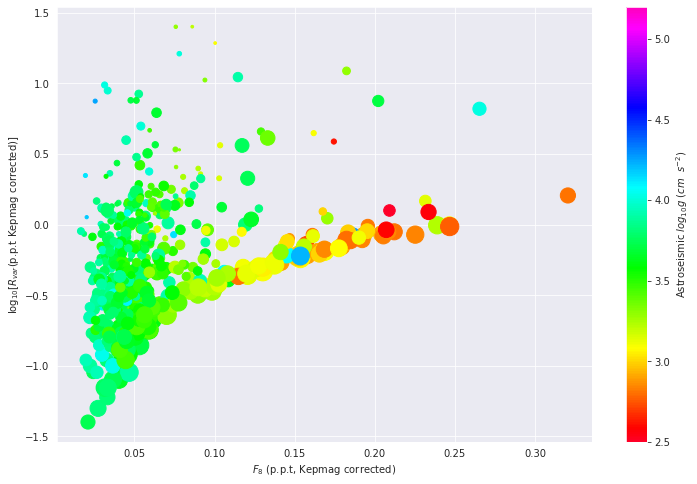

In [ ]:
x = df['F_8(Corr)']
y = np.log10(df['R(Corr)'])
c = df['LogG']
s = df['Zcross']
plt.figure(figsize = (12,8))
img = plt.scatter(x,y,c=c*0.9,s=s*1.5,cmap='gist_rainbow',vmin=2.5,vmax=5.2)
plt.colorbar(img,label=r'Astroseismic $log_{10}g$ ($cm$  $s^{-2}$)')
plt.xlabel(r'$F_8$ (p.p.t, Kepmag corrected)')
plt.ylabel(r'$\log_{10}[R_{var}$(p.p.t Kepmag corrected)]')

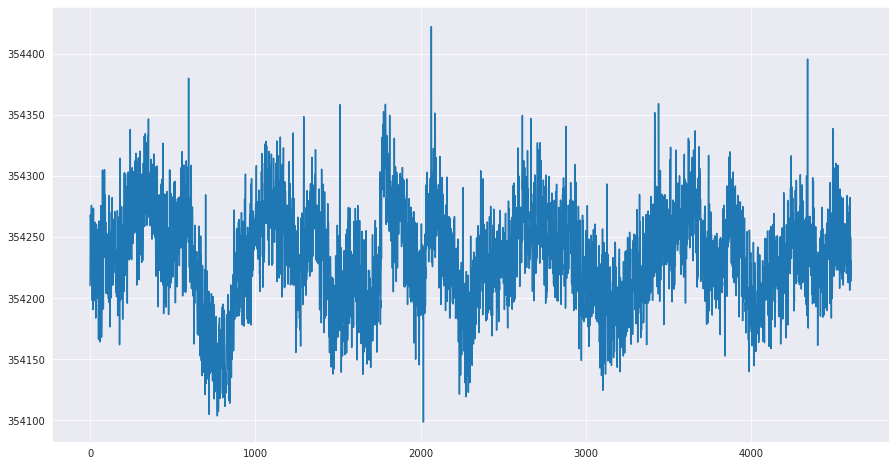

In [ ]:
plt.plot(flux)

In [ ]:
source.KEPMAG, source.LOGG

(10.875, 4.105)